In [2]:
def warpPerspectivePadded(
        src, dst_shape, M):
    """Performs an affine or Euclidean/rigid warp with padding.
    Parameters
    ----------
    src : image to be warped.
    dst : shape of static image i.e. dst.shape 
    M : `3x3` Homography matrix.
    Returns
    -------
    src_warped : padded and warped source image
    """
    
    # it is enough to find where the corners of the image go to find
    # the padding bounds; points in clockwise order from origin
    _, src_w = src.shape[:2]
    lin_pts = np.array([
        [0, src_w],
        [0, 0]])
    # transform points
    transf_lin_pts = M[:, :2].dot(lin_pts) + M[:, 2].reshape(3, 1)

    # find min and max points
    min_x = np.floor(np.min(transf_lin_pts)).astype(int)
    max_x = np.ceil(np.max(transf_lin_pts)).astype(int)

    # add translation to the transformation matrix to shift to positive values
    anchor_x = 0
    if min_x < 0:
        anchor_x = -min_x
    shifted_transf = M + [[0, 0, anchor_x], [0, 0, 0], [0, 0, 0]]

    # create padded destination image
    dst_h, dst_w,_ = dst_shape
    dst_pad_w = anchor_x + dst_w + max(max_x, dst_w) - dst_w
    src_warped = cv2.warpPerspective(src, shifted_transf, (dst_pad_w, dst_h), borderMode=cv2.BORDER_CONSTANT, borderValue=0)
    return src_warped

In [3]:
def Ramp(i_width, r_width, r_index, start, end):
    """
    Create alpha blending function
    :param i_width: img width
    :param r_width: ramp width
    :param r_index: center ramp index
    :param start: starting ramp value
    :param end: ending ramp value
    :return:
    """
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))  # left side starting index of alpha ramp
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

(Text(0.5,1,'Pyramid Blending'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

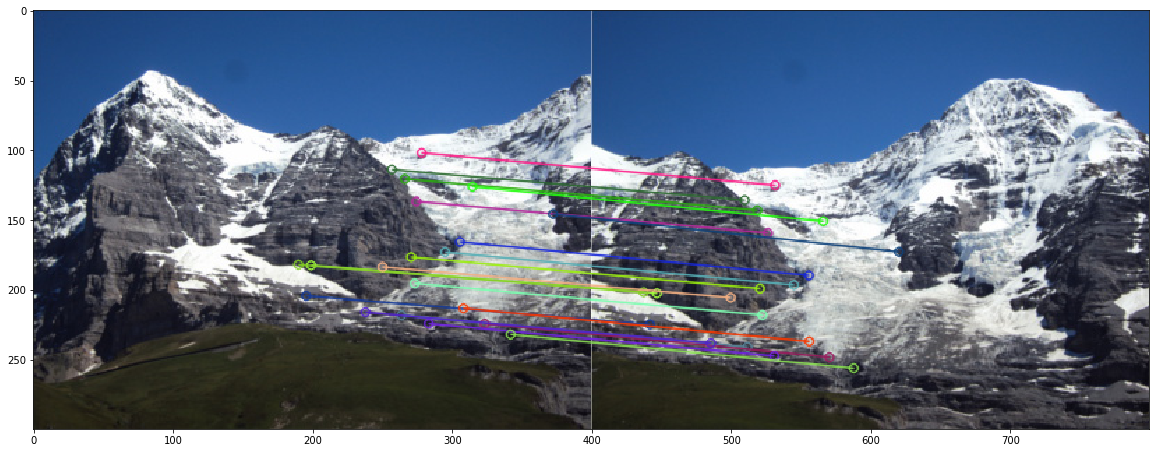

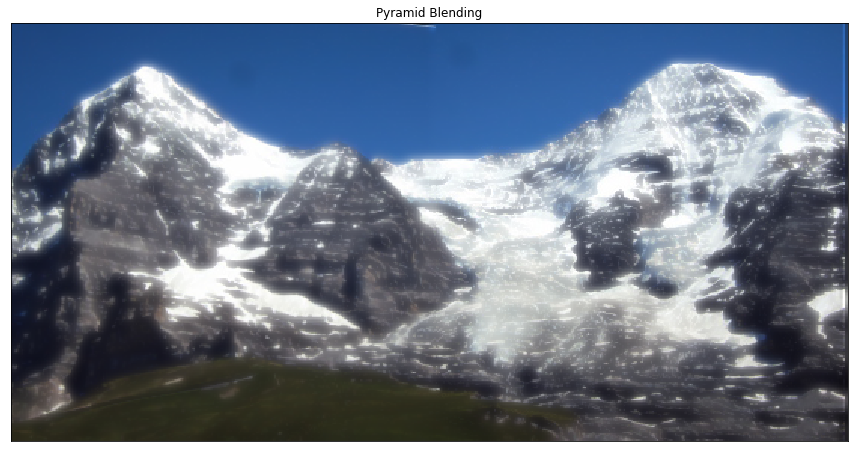

In [16]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

img1 = cv2.imread('stitching_images/1Hill.JPG')
img2 = cv2.imread('stitching_images/2Hill.JPG')

img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
sift_obj = cv2.xfeatures2d.SIFT_create()
keypoints_1, descriptors_1 = sift_obj.detectAndCompute(img1, None)
keypoints_2, descriptors_2 = sift_obj.detectAndCompute(img2, None)

# surf_test = cv2.xfeatures2d.SURF_create()
# keypoints_1_surftest, descriptors_1_surftest = surf_test.detectAndCompute(img1, None)
# print(len(keypoints_1))
# print(len(keypoints_1_surftest))

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_1, descriptors_2)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(img1,keypoints_1,img2,keypoints_2, matches[:20], img1, flags=2)

GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

plt.figure(figsize=(20,20))
plt.imshow(imgmatch)

mp1 = np.float32([keypoints_1[i].pt for (__, i) in GoodMatches])
mp2 = np.float32([keypoints_2[i].pt for (i, __) in GoodMatches])

H, __ = cv2.findHomography(mp1, mp2, cv2.RANSAC)
wimg1 = warpPerspectivePadded(img1, (img1.shape[0], img1.shape[1], img1.shape[2]), H)
# wimg1[:,:wimg1.shape[1],:] = wimg1

# temp = wimg1.copy()
# temp[:,wimg1.shape[1]-img2.shape[1]:wimg1.shape[1],:] = img2
wimg1 = cv2.copyMakeBorder(wimg1, 0, 0, 0, 1, cv2.BORDER_CONSTANT)
img2 = cv2.copyMakeBorder(img2, 0, 0, 154, 2, cv2.BORDER_CONSTANT)

# parameters
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

""" PYRAMID BLENDING """
row, col, dpt = wimg1.shape
# generate Gaussian pyramid for imgA
G = wimg1.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# generate Laplacian pyramid for imgA
lp1 = [gp1[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# generate Gaussian pyramid for imgB
G = img2.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# generate Laplacian pyramid for imgB
lp2 = [gp2[depth-1]]  # store last gaussian image for top of lp pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)
    
# add left and right halves of images in each level
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    rs = cv2.add(rs, LP[i])  # add lp image
    
# display results
plt.figure(figsize=(15,15))
plt.imshow(rs[22:rs.shape[1],:])
plt.title('Pyramid Blending'), plt.xticks([]), plt.yticks([])


(400, 1058, 3) (400, 1058, 3)


(Text(0.5,1,'Linear Blending'),
 ([], <a list of 0 Text xticklabel objects>),
 ([], <a list of 0 Text yticklabel objects>))

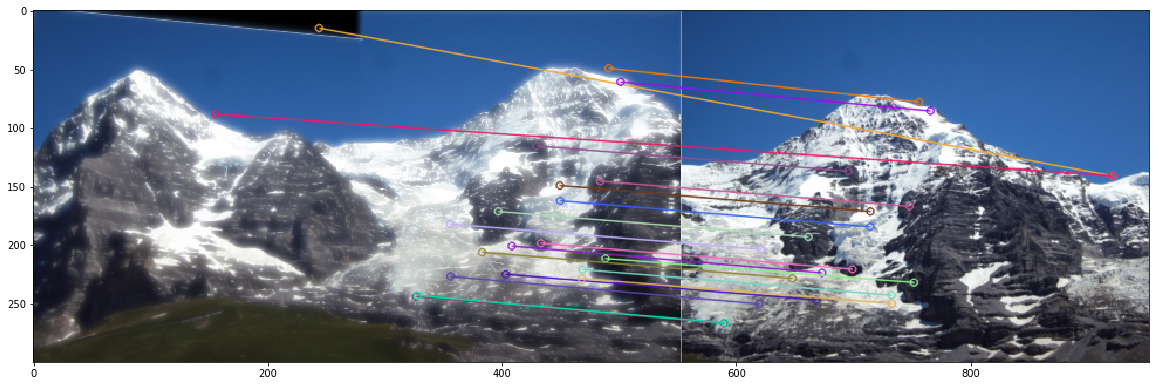

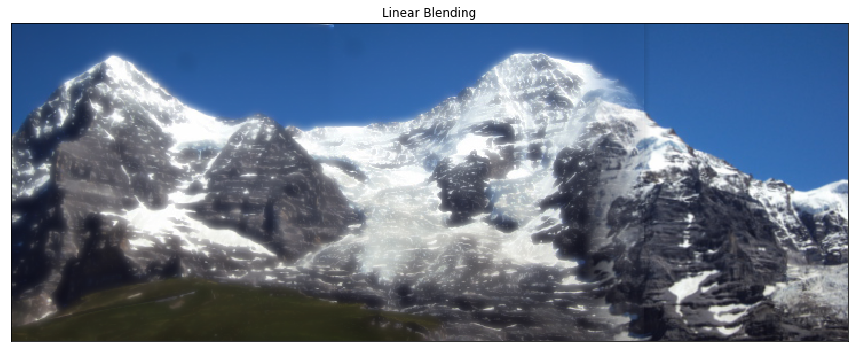

In [7]:
hill12=rs[0:rs.shape[0], 0:rs.shape[1]-3]
hill3 = cv2.imread('stitching_images/3Hill.JPG')

hill3 = cv2.cvtColor(hill3, cv2.COLOR_BGR2RGB)

# Compute keypoints and descriptors
surf_obj = cv2.xfeatures2d.SURF_create()
keypoints_12, descriptors_12 = surf_obj.detectAndCompute(hill12, None)
keypoints_3, descriptors_3 = surf_obj.detectAndCompute(hill3, None)

# create BFMatcher object
bf = cv2.BFMatcher()

# Match descriptors.
matches = bf.match(descriptors_12, descriptors_3)

# Sort them in the order of their distance.
matches = sorted(matches, key = lambda x:x.distance)

# Draw keypoints 
imgmatch = cv2.drawMatches(hill12,keypoints_12,hill3,keypoints_3, matches[:20], hill12, flags=2)

GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))

plt.figure(figsize=(20,20))
plt.imshow(imgmatch)

mp12 = np.float32([keypoints_12[i].pt for (__, i) in GoodMatches])
mp3 = np.float32([keypoints_3[i].pt for (i, __) in GoodMatches])

H, __ = cv2.findHomography(mp12, mp3, cv2.RANSAC)
whill3 = warpPerspectivePadded(hill3, (400, hill3.shape[1], hill3.shape[2]), H)

hill12 = cv2.copyMakeBorder(hill12, 0, 100, 0, 1058-hill12.shape[1], cv2.BORDER_CONSTANT)
whill3 = cv2.copyMakeBorder(whill3, 0, 0, 1058-whill3.shape[1], 0, cv2.BORDER_CONSTANT)

ramp_size = 60  # alpha blending ramp size
alpha = Ramp(hill12.shape[1], ramp_size, round(hill12.shape[1]/2), 0, 1)

print(whill3.shape, hill12.shape)
# Now blend
I_blend = (1-alpha.reshape(1,-1,1)) * hill12 + alpha.reshape(1,-1,1)*whill3
I_blend = np.uint8(I_blend)  # convert back to uint8

I_blend_cut=I_blend[22:rs.shape[0], 0:I_blend.shape[1]-327]

plt.figure(figsize=(15,15))
plt.imshow(I_blend_cut)
plt.title('Linear Blending'), plt.xticks([]), plt.yticks([])


2.2 Reasoning Question

1. Difference between SIFT and SURF:

    speed: SURF is faster than SIFT

    number of keypoint: SIFT calculates more keypoints than SURF. running both methods on Hill1 we get 1254 points from SIFT and 896 points from SURF

    density: SIFT is more dense than SURF. this is in correspondance with the keypoints
    


2. Pros and Cons of Linear Blending and Pyramid

    Linear blending is simple and relatively not complicated algorithm. Does not preserve parallelism and the strength of the pixel on the stitched image depends on it's location on the original image. Therefore some pixels get overpowered by the other image's pixels too much.

    Pyramid blending is good for smooth transition between images and good for texture analysis. It is not great at stitching images with different exposures, and if there are moving objects in the images it turns them into 'ghosts'


3. Random set of matching keypoint pairs

    The homography between two images is more accurate if we use the best matching keypoints. Using a random subset of keypoints will decrease the accuracy of homography as the algorithm might find keypoints that do not actually match. -> 'Bad' feature matches 


4. Relation between the number of keypoints and accuracy

    The algorithm will try to find the specified number of keypoints that match in two images. Increasing the number of keypoints will increase the accuracy of homography until we reach a treshold. This treshold is the number of total matching keypoints in the images. Increasing the keypoints (we pass as a parameter to the algorithm) above the treshold will not increase the accuracy of homography, in fact it might result in keypoint match for features that do not actually match which in the end might decrease the accuracy. 